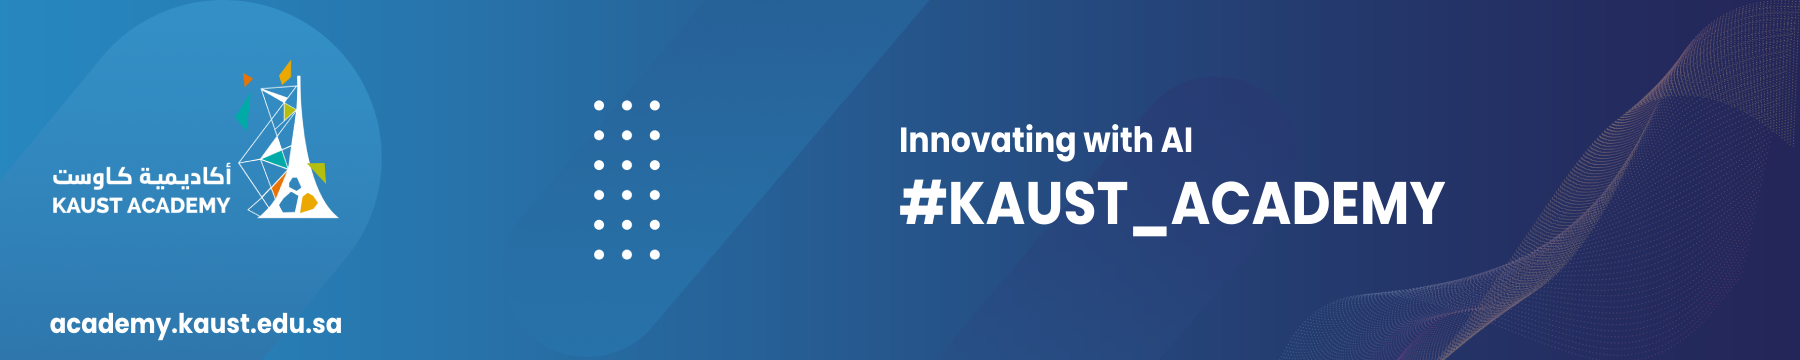

In [ ]:
from IPython.display import clear_output

## Set up a virtual display

Mujoco rendering requires a display(even if we want to just generate rgb_array frames). A colab notebook does not have a display. Therefore we need to account for that by creating a virtual display

In [ ]:
%%capture
!apt install -y python3-opengl
!apt install -y ffmpeg
!apt install -y xvfb
!pip3 install pyvirtualdisplay

clear_output()

In [ ]:
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
%pip install gymnasium[mujoco]

clear_output()

In [ ]:
# %pip install torch numpy matplotlib

clear_output()

# Contents

In this demo, we will implement the DDPG algo using pytorch and then use it to train the **walker** environment. The algorithm implementation is heavily inspired from [This repo](https://github.com/tinyzqh/awesome-reinforcement-learning/tree/master)

Walker environment consists of a structure of legs and the agent's actions can move the joints. The goal is to make the structure able to walk.

You can see more about the actions, observations and rewards [here](https://gymnasium.farama.org/environments/mujoco/walker2d/)

![Walker Image](https://gymnasium.farama.org/_images/walker2d.gif)


## DDPG Algorithm


DDPG (Deep Deterministic Policy Gradient) is an algorithm designed for environments with continuous action spaces. It is inspired by the DPG (Deterministic Policy Gradient) algorithm, but extends it with the power of deep learning to handle high-dimensional state and action spaces effectively.

DDPG operates under the actor-critic framework. It uses two neural networks: an actor network, which proposes actions given the current state, and a critic network, which evaluates these actions by estimating the Q-value function. The key idea is to update the actor's policy by following the gradient of the critic's Q-value function, leading to improved action choices over time.

The core mechanisms of DDPG include:

1. Target Networks: To stabilize training, DDPG employs target networks for both the actor and critic. These networks are slowly updated versions of the original networks, which help mitigate the risk of divergence by providing more stable target values.

2. Experience Replay: DDPG uses a replay buffer to store past experiences (state, action, reward, next state tuples). During training, mini-batches of these experiences are sampled uniformly to break correlations between consecutive updates and improve data efficiency.

3. Soft Updates: Instead of directly copying weights from the main networks to the target networks, DDPG performs soft updates, where the target networks' weights are slowly blended with the main networks' weights. This process smooths out learning and helps stabilize training.

4. Exploration Noise: To encourage exploration in the action space, DDPG adds noise to the actions proposed by the actor during training. This noise is typically generated by an Ornstein-Uhlenbeck process, which produces temporally correlated values suitable for physical control tasks.

DDPG is particularly effective for continuous action domains, such as robotic control and autonomous driving, due to its ability to learn precise action values and its use of neural networks to approximate complex functions. However, it can be sensitive to hyperparameters and requires careful tuning to achieve optimal performance.

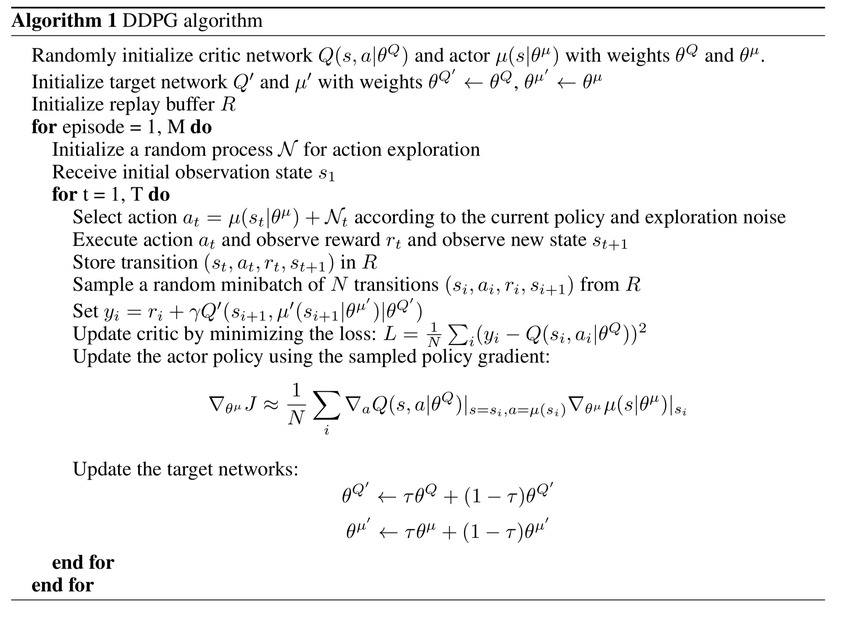

In [ ]:
import torch
import gymnasium as gym
import numpy as np
import collections
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

## Implementing the model

In [ ]:
Experience = collections.namedtuple(typename="Experience", field_names=['state', 'action', 'reward', 'done', 'nextState'])


class ExperienceBuffer(object):
    def __init__(self, args):
        self.buffer = collections.deque(maxlen=args['replay_size'])

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=True)
        states, actions, rewards, done, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), actions, np.array(rewards, dtype=np.float32), done, np.array(next_states)


class Actor(nn.Module):
    def __init__(self, input_dim, output_dim, action_scale):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, output_dim)
        self.action_scale = action_scale

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.action_scale * torch.tanh(self.fc3(x))
        return x


class Critic(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, output_dim)

    def forward(self, state, action):
        x = F.relu(self.fc1(torch.cat([state, action], 1)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Agent(object):
    def __init__(self, env, exp_buffer, args):
        super(Agent, self).__init__()
        self.env = env
        self.exp_buffer = exp_buffer
        self.args = args
        self.actor = None
        self.critic = None
        self.target_actor = None
        self.target_critic = None
        self.build_model()
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.args['actor_lr'])
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.args['critic_lr'])

    def build_model(self):
        obs_dim = self.env.observation_space.shape[0]
        action_dim = self.env.action_space.shape[0]
        action_scale = self.env.action_space.high[0]

        self.actor = Actor(input_dim=obs_dim, output_dim=action_dim, action_scale=action_scale).to(device)
        self.target_actor = Actor(input_dim=obs_dim, output_dim=action_dim, action_scale=action_scale).to(device)
        self.target_actor.load_state_dict(self.actor.state_dict())

        self.critic = Critic(input_dim=obs_dim+action_dim, output_dim=1).to(device)
        self.target_critic = Critic(input_dim=obs_dim+action_dim, output_dim=1).to(device)
        self.target_critic.load_state_dict(self.critic.state_dict())

    def choose_action(self, state):
        x = torch.unsqueeze(torch.FloatTensor(state).to(device), 0)
        return self.actor(x)

    def store_transition(self, state, action, r, done, state_next):
        exp = Experience(state, action, r, done, state_next)
        self.exp_buffer.append(exp)

    def learn(self):
        for _ in range(0, self.args['update_iteration']):

            buffer = self.exp_buffer.sample(self.args['batch_size'])
            states, actions, rewards, done, next_states = buffer

            states_tensor = torch.FloatTensor(states).to(device)
            actions_tensor = torch.FloatTensor(actions).to(device)
            rewards_tensor = torch.unsqueeze(torch.FloatTensor(rewards), 1).to(device)
            done_tensor = torch.unsqueeze(1-torch.FloatTensor(done), 1).to(device)
            next_states_tensor = torch.FloatTensor(next_states).to(device)

            # Compute the target Q value
            target_q = self.target_critic(next_states_tensor, self.target_actor(next_states_tensor))
            target_q = rewards_tensor + (done_tensor * self.args['gamma'] * target_q).detach()

            # Get current Q estimate
            current_q = self.critic(states_tensor, actions_tensor)

            # Compute critic loss
            critic_loss = F.mse_loss(current_q, target_q)
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Compute actor loss
            actor_loss = -self.critic(states_tensor, self.actor(states_tensor)).mean()
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.target_critic.parameters()):
                target_param.data.copy_(self.args['tau'] * param.data + (1 - self.args['tau']) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.target_actor.parameters()):
                target_param.data.copy_(self.args['tau'] * param.data + (1 - self.args['tau']) * target_param.data)

In [ ]:
def frames_to_video(frames, fps=24):
    fig = plt.figure(figsize=(frames[0].shape[1] / 100, frames[0].shape[0] / 100), dpi=100)
    ax = plt.axes()
    ax.set_axis_off()

    if len(frames[0].shape) == 2:  # Grayscale image
        im = ax.imshow(frames[0], cmap='gray')
    else:  # Color image
        im = ax.imshow(frames[0])

    def init():
        if len(frames[0].shape) == 2:
            im.set_data(frames[0], cmap='gray')
        else:
            im.set_data(frames[0])
        return im,

    def update(frame):
        if len(frames[frame].shape) == 2:
            im.set_data(frames[frame], cmap='gray')
        else:
            im.set_data(frames[frame])
        return im,

    interval = 1000 / fps
    anim = FuncAnimation(fig, update, frames=len(frames), init_func=init, blit=True, interval=interval)
    plt.close()
    return HTML(anim.to_html5_video())

## Initializing the model and environment

In [ ]:
args = {
    'replay_size': 20000,
    'batch_size': 128,
    'actor_lr': 1e-4,
    'critic_lr': 1e-3,
    'tau': 0.005,
    'exploration_noise': 0.1,
    'update_iteration': 200,
    'gamma': 0.99
}

In [ ]:
buffer = ExperienceBuffer(args=args)
env = gym.make('Walker2d-v4', render_mode='rgb_array')
agent = Agent(env, buffer, args)

## Untrained walker

In [ ]:
state = env.reset()[0]
frames = []

while True:
    with torch.no_grad():
        action = agent.choose_action(state).cpu().numpy().flatten()
        state_next, r, done, truncated, info = env.step(action)
        frames.append(env.render())
        state = state_next
        if done or truncated:
            break

In [ ]:
frames_to_video(frames)

## Train the model

This takes a CONSIDERABLE amount of time.

In [ ]:
for epoch in range(20000):
    state, done, truncated = env.reset()[0], False, False
    episode_r = []
    while (not done) and (not truncated):
        action = agent.choose_action(state).cpu().detach().numpy().flatten()
        action = (action + np.random.normal(0, args['exploration_noise'], size=env.action_space.shape[0])).clip(
            env.action_space.low, env.action_space.high)
        state_next, r, done, truncated, info = env.step(action)
        agent.store_transition(state, action, r, done, state_next)
        if not done:
            state = state_next
        episode_r.append(r)
    agent.learn()
    print("epoch: {} | avg_r: {} | ep_r: {} | len_ep {}".format(epoch, np.sum(episode_r) / len(episode_r),
                                                                sum(episode_r), len(episode_r)))
env.close()

## Post-training Walker

In [ ]:
state = env.reset()[0]
frames = []

while True:
    with torch.no_grad():
        action = agent.choose_action(state).cpu().numpy().flatten()
        state_next, r, done, truncated, info = env.step(action)
        frames.append(env.render())
        state = state_next
        if done or truncated:
            break

In [ ]:
frames_to_video(frames)